In [135]:
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import torch.nn.functional as F
from tqdm.auto import tqdm
import segmentation_models_pytorch as smp
import cv2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size=1
image_count=50
img_size=512
tf = ToTensor()
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [119]:
test_image_list=glob('../../data/1-cycle_30%_중간데이터/segmentation/test/image/*.tiff')
test_mask_list=[f.replace('/image/', '/polygon/TP_tumor/') for f in test_image_list]


class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list
        self.label = label_list
    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        image_tensor = self.img_path[idx]
        label_tensor =  self.label[idx]
        return image_tensor, label_tensor

test_image=torch.zeros((len(test_image_list),3,img_size,img_size))
test_mask=torch.zeros((len(test_image_list),1,img_size,img_size))

    
for i in tqdm(range(len(test_image_list))):
    img=1-tf(np.array(expand2square(Image.open(test_image_list[i]),(255,255,255)).resize((img_size,img_size))))
    msk=tf(np.array((expand2square(Image.open(test_mask_list[i]),(0,0,0)).convert('L')).resize((img_size,img_size))))
    test_image[i]=img
    test_mask[i]=msk


test_dataset = CustomDataset(test_image[:len(test_image_list)//2], test_mask[:len(test_image_list)//2])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/423 [00:00<?, ?it/s]

In [136]:
model=smp.UnetPlusPlus('efficientnet-b6').to(device)
summary(model,(batch_size,3,img_size,img_size))
def diceloss(pred, target):
    smooth = 1.
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )
def calc_loss(pred, target, metrics, bce_weight=0.7):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = diceloss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss
model.load_state_dict(torch.load('../../model/NestedUNet_callback.pt'))


<All keys matched successfully>

In [137]:
total_y = torch.zeros((len(test_dataloader), 3,img_size,img_size)).to(device)
total_x = torch.zeros((len(test_dataloader), 3,img_size,img_size)).to(device)
total_prob = torch.zeros((len(test_dataloader), 3,img_size,img_size)).to(device)
model.eval()
count=0
val_running_loss=0.0
acc_loss=0
test=tqdm(test_dataloader)
metrics = defaultdict(float)
with torch.no_grad():
    for x, y in test:
        y = y.to(device).float()
        x=x.to(device).float()
        predict = model(x).to(device)
        cost = calc_loss(predict, y,metrics) # cost 구함
        acc=1-calc_loss(predict, y,metrics)
        val_running_loss+=cost.item()
        acc_loss+=acc
        prob_pred = predict
        total_x[count]=x.squeeze(dim=1)
        total_y[count] = y.squeeze(dim=1)
        total_prob[count] = prob_pred
        count+=1
print(f'dice_score={acc_loss/count}')

  0%|          | 0/211 [00:00<?, ?it/s]

dice_score=0.904765248298645


Text(0.5, 1.0, 'Predict')

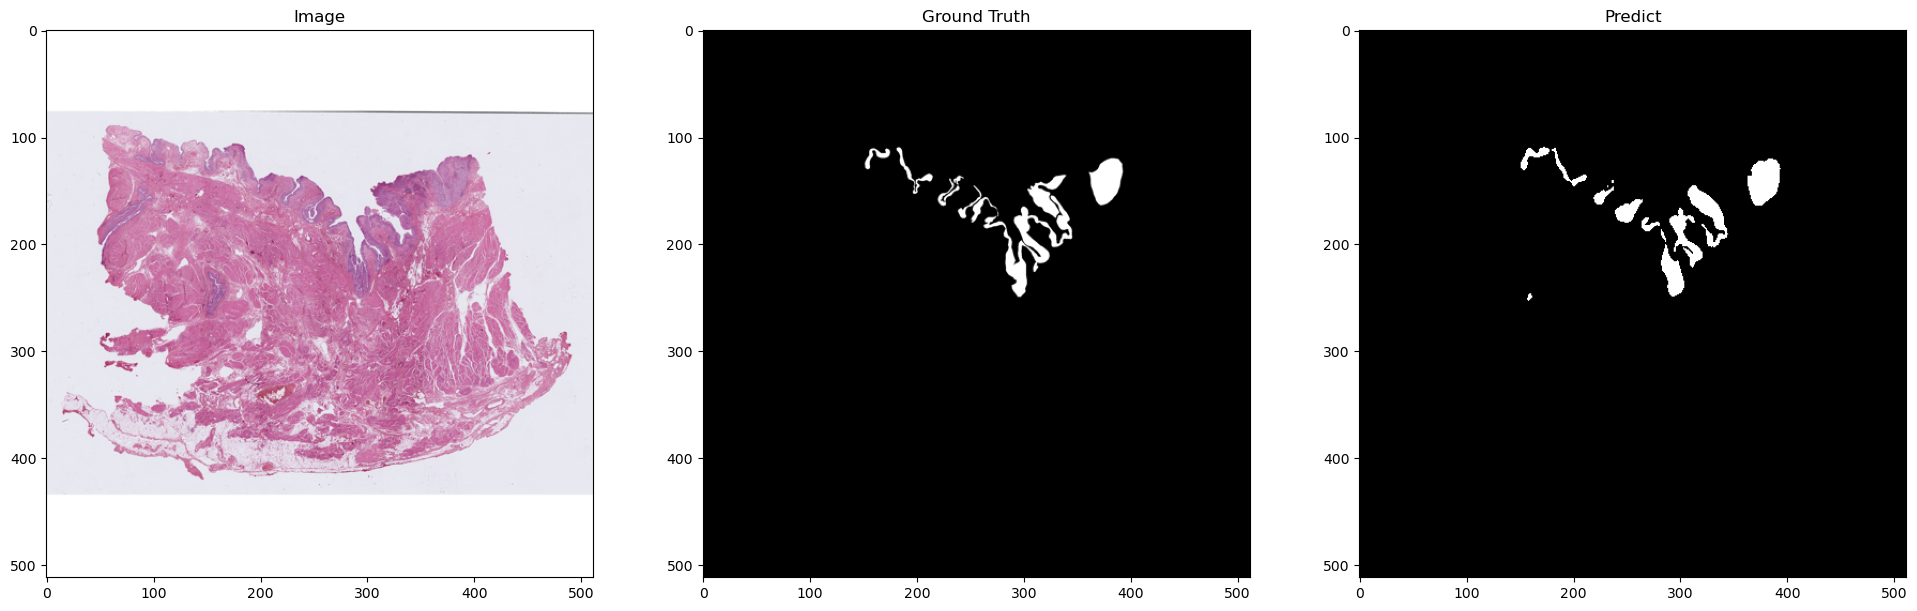

In [138]:
from matplotlib import cm


tf=transforms.ToPILImage()
i=21
plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
plt.imshow(tf(1-total_x[i].cpu()))
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(total_y[i,0].cpu(),cmap='gray')
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(torch.where(F.sigmoid(total_prob.cpu())>0.5,1,0)[i][0],cmap='gray')
plt.title('Predict')

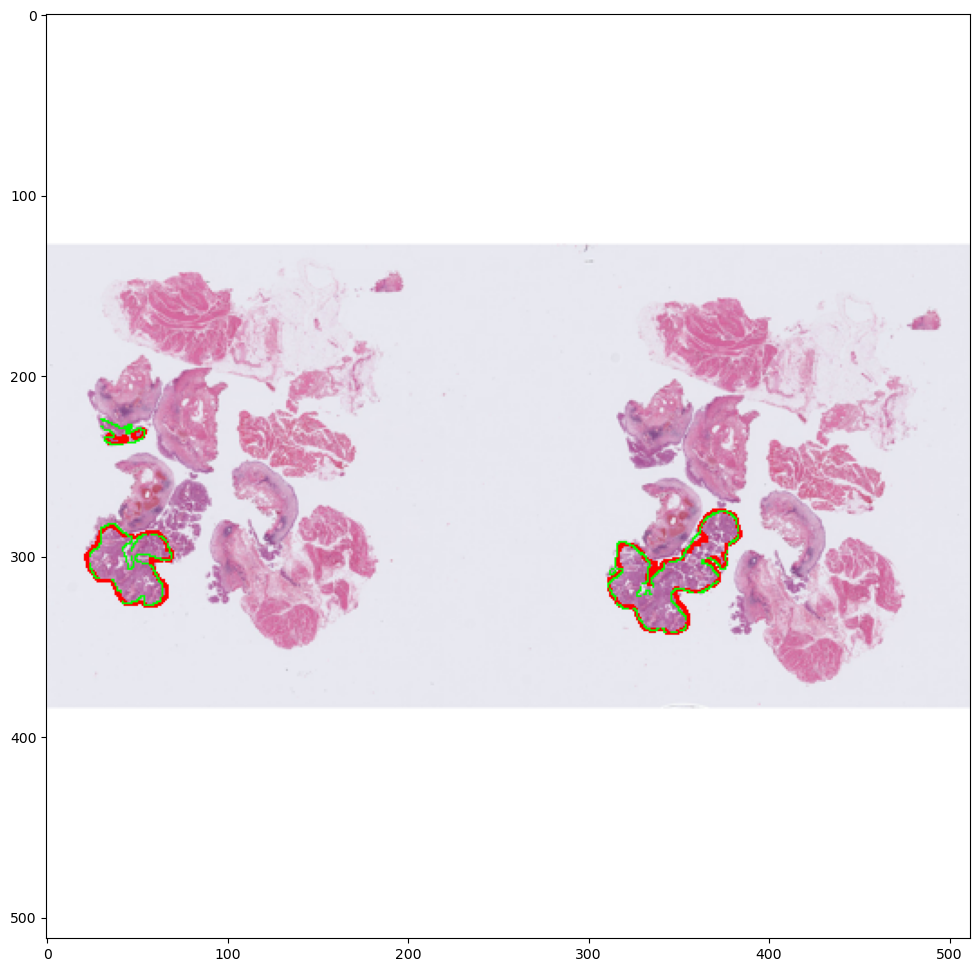

In [139]:
for i in range(len(total_y)):
    ground_truth=np.array(total_y[i,0].cpu())
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    # 열림 연산 적용 ---②
    ground_truth_gradient = cv2.morphologyEx(ground_truth, cv2.MORPH_GRADIENT, k)

    predict_mask=np.array(torch.where(F.sigmoid(total_prob.cpu())>0.5,1,0)[i][0],dtype=np.uint8)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    # 열림 연산 적용 ---②
    predict_mask_gradient = cv2.morphologyEx(predict_mask, cv2.MORPH_GRADIENT, k)
    image=np.array(tf(1-total_x[i].cpu()))
    dst_image=np.copy(image)
    dst_image[np.where(predict_mask_gradient==1)]=[255,0,0]
    dst_image[np.where(ground_truth_gradient==1)]=[0,255,0]
    Image.fromarray(dst_image).save('../../data/predict/GT_PR_Image/'+str(i)+'.png')


plt.figure(figsize=(12,12))
plt.imshow(dst_image)